In [1]:
import numpy as np
import pandas as pd
import mpl_scatter_density
import matplotlib.pyplot as plt

from pyometiff import OMETIFFWriter
from matplotlib.colors import Normalize
from skimage.measure import label, regionprops
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import binary_dilation, gaussian_filter

/Users/kuanlin/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
plt.rc('font', family = 'serif', size = 13, weight = "bold")
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', linewidth = 2)
plt.rc('lines', linewidth = 3)
plt.rc('figure', figsize = (5, 5), dpi = 80)
plt.rc('legend', fontsize = 13)

cm = plt.cm.get_cmap('tab20')

<ipython-input-2-6cc2a6022caa>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


### Load in the image

In [3]:
sender_image = plt.imread("./Sample_Data/Txn_series1_0min_sender.tif")
receiver_image = plt.imread("./Sample_Data/Txn_series1_0min_receiver.tif")

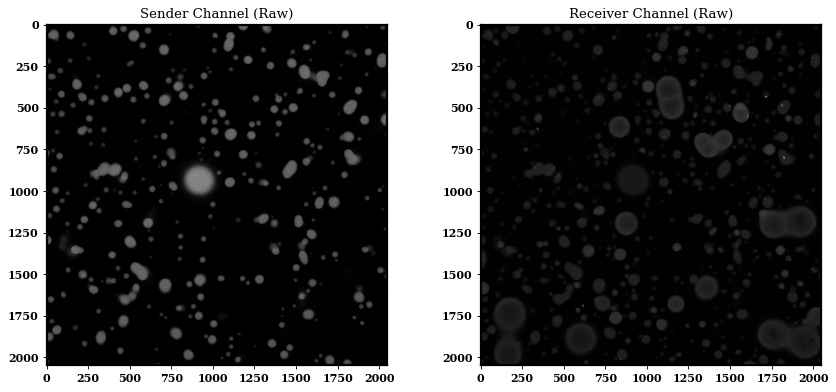

In [4]:
fig = plt.figure(figsize=(11, 5), dpi = 80)

plt.subplot(1, 2, 1)
plt.title("Sender Channel (Raw)")
plt.imshow(sender_image, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Receiver Channel (Raw)")
plt.imshow(receiver_image, cmap="gray")

plt.tight_layout()
plt.show()

### Helper Function - saving tig images

In [5]:
def save_ome_tif(filename, img):
    """
    Save the ome.tif file.
    """
    writer = OMETIFFWriter(fpath = filename, array = img, metadata = {})
    writer.write()

### Sender receiver droplet identification

In [6]:
def droplet_detection(sender_image, receiver_image):
    """
    Identify the locations of the sender and receiver droplets.
    """
    # Create Binary for better signal to noise
    binary = sender_image > (sender_image.mean() + sender_image.std())

    # use labeling function to identify connected blobs
    label_im = label(binary)
    blob_lists = regionprops(label_im)

    # Remove small blobs
    senders = [i for i in blob_lists if i.area > 500]
    
    # Mask to document all sender locations
    mask = np.zeros_like(binary)
    for i in senders:
        minr, minc, maxr, maxc = i.bbox
        mask[minr:maxr, minc:maxc] = 1
        
    # Create Binary for better signal to noise
    binary = receiver_image > (receiver_image.mean() + receiver_image.std())
    
    # use labeling function to identify connected blobs
    label_im = label(binary)
    blob_lists = regionprops(label_im)

    # Remove small blobs
    receivers = [i for i in blob_lists if i.area > 500]

    # Extract receiver droplets
    true_receivers = []
    for i in receivers:
        minr, minc, maxr, maxc = i.bbox
        if mask[int((minr+maxr)/2), int((minc+maxc)/2)] == 0:
            true_receivers.append(i)
            
    return senders, true_receivers

In [7]:
senders, receivers = droplet_detection(sender_image, receiver_image)

### Single-channel droplet identification

In [8]:
def droplet_detection_single_channel(image):
    """
    Identify the locations of the droplets.
    """
    # Create Binary for better signal to noise
    binary = image > (image.mean() + image.std())

    # use labeling function to identify connected blobs
    label_im = label(binary)
    blob_lists = regionprops(label_im)

    # Remove small blobs
    droplets = [i for i in blob_lists if i.area > 500]
    
    return droplets

In [9]:
droplets = droplet_detection_single_channel(sender_image)

### Extract the pixel values of droplets - Filter Method

In [10]:
def droplet_value_extraction_v2(droplets, image, filename = False, dilation = False):
    """
    Extract the intensity value of the droplets. Can save as a txt file for later plotting.
    """
    
    values = []
    
    if dilation:
        
        for blob in droplets:

            minr, minc, maxr, maxc = blob.bbox
            blob_img = image[minr:maxr, minc:maxc]
            vals = blob_img[binary_dilation(blob.image)]
            values.append(vals)

        values = np.concatenate(values)
        
    else:
    
        for blob in droplets:

            minr, minc, maxr, maxc = blob.bbox
            blob_img = image[minr:maxr, minc:maxc]
            vals = blob_img[blob.image]
            values.append(vals)

        values = np.concatenate(values)
    
    if filename: np.savetxt(filename, values, fmt='%f')
    
    return values

In [11]:
sender_values = droplet_value_extraction_v2(senders, receiver_image)

print("Mean:\t{:.2f}\nStd:\t{:.2f}\nMin:\t{:.2f}\nMax:\t{:.2f}".format(np.mean(sender_values), np.std(sender_values), np.min(sender_values), np.max(sender_values)))


Mean:	6397.14
Std:	2732.14
Min:	85.00
Max:	63104.00


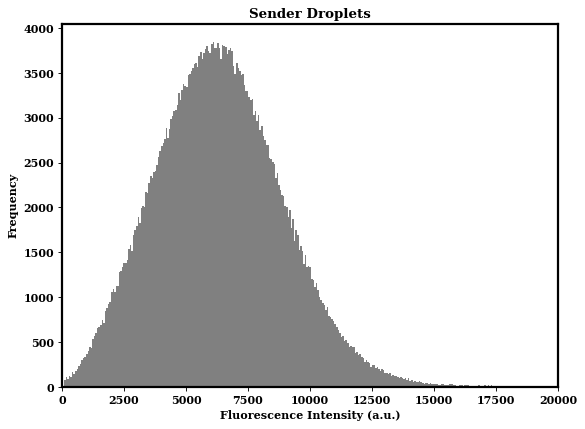

In [12]:
figure = plt.figure(figsize = (8, 6), dpi = 80)

plt.hist(sender_values, bins = 1000, color = 'grey')
plt.title("Sender Droplets", weight = "bold")
plt.xlabel("Fluorescence Intensity (a.u.)", weight = "bold")
plt.ylabel("Frequency", weight = "bold")
plt.xlim(0, 20000)
plt.show()

In [13]:
receiver_values = droplet_value_extraction_v2(receivers, receiver_image, dilation = True)

print("Mean:\t{:.2f}\nStd:\t{:.2f}\nMin:\t{:.2f}\nMax:\t{:.2f}".format(np.mean(receiver_values), np.std(receiver_values), np.min(receiver_values), np.max(receiver_values)))


Mean:	8487.25
Std:	3046.69
Min:	160.00
Max:	43830.00


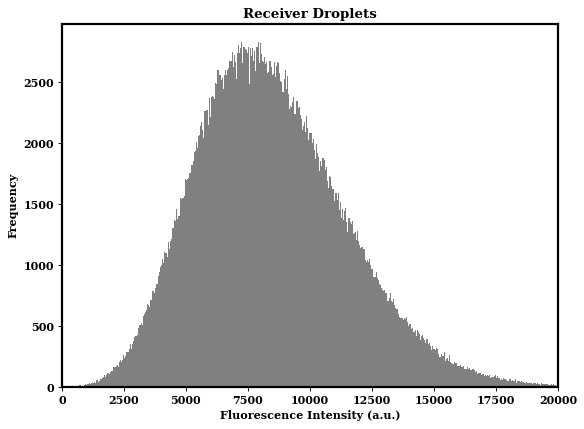

In [14]:
figure = plt.figure(figsize = (8, 6), dpi = 80)

plt.hist(receiver_values, bins = 1000, color = 'grey')
plt.title("Receiver Droplets", weight = "bold")
plt.xlabel("Fluorescence Intensity (a.u.)", weight = "bold")
plt.ylabel("Frequency", weight = "bold")
plt.xlim(0, 20000)
plt.show()

### Generate droplet-annotated images

In [15]:
def droplet_annotation(image, droplet, RAW = False, filename = False):
    """
    Saves the image with droplets annotated.
    
    RAW = True -> plots the raw image.
    
    RAW = False -> plots the amplified binary image.
    
    Set up a filename to save the image.
    """
    
    figure = plt.figure(figsize=(8, 8), dpi = 80)

    ax = plt.subplot(1,1,1)
    
    if RAW:
        plt.imshow(image, cmap = "gray")
    else:
        binary = image > (image.mean() + image.std())
        plt.imshow(binary, cmap = "gray")
        

    for i in droplet:
        minr, minc, maxr, maxc = i.bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2, alpha=.8)
        ax.add_patch(rect)
        ax.set_axis_off()
        
    if filename:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    plt.show()

Sender Droplets


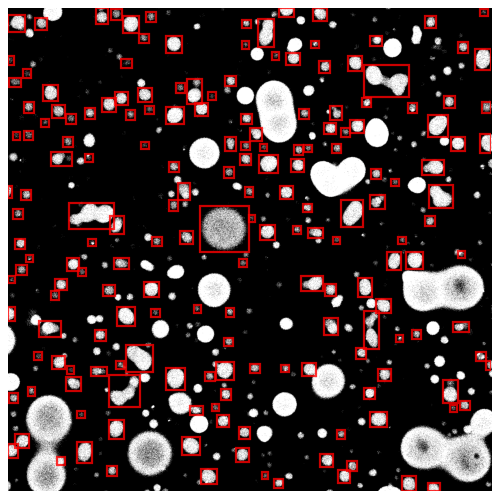

In [16]:
print("Sender Droplets")
droplet_annotation(receiver_image, senders, RAW = False, filename = "./Sample_Data/test.png")

Receiver Droplets


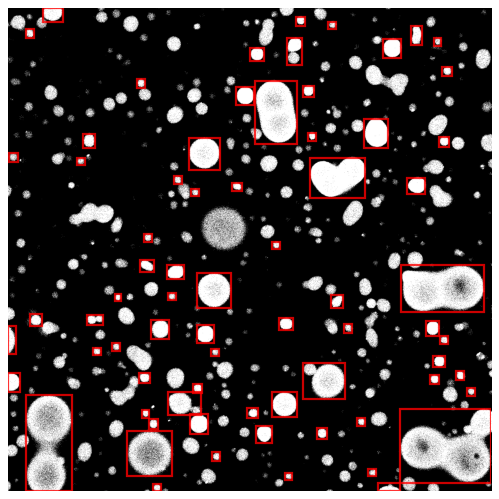

In [17]:
print("Receiver Droplets")
droplet_annotation(receiver_image, receivers, RAW = False)

### Generate images only containing senders and receivers

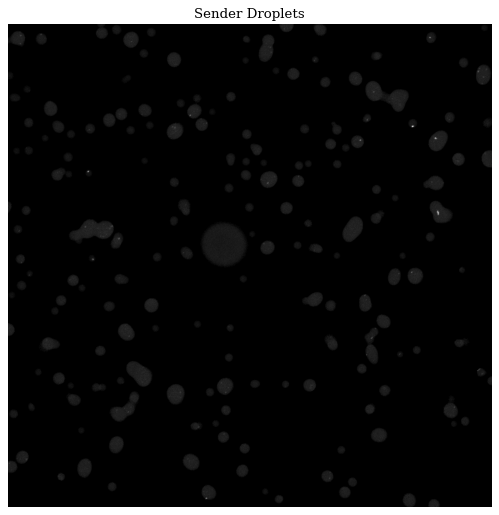

In [18]:
blank = np.zeros_like(sender_image)

for droplet in senders:

    minr, minc, maxr, maxc = droplet.bbox
    
    cropped = receiver_image[minr:maxr, minc:maxc]
    
    mask = droplet.image
    
    for r in range(minr, maxr):
        for c in range(minc, maxc):
            r_r = r - minr
            r_c = c - minc
            if mask[r_r, r_c]:
                blank[r, c] = cropped[r_r, r_c]
    
figure = plt.figure(figsize=(8, 8), dpi = 80)

plt.title("Sender Droplets")

plt.imshow(blank, cmap = 'gray')

plt.axis(False)

# save_ome_tif("Txn_series6_30min_sender_cropped.tif", blank.reshape(1, 2048, 2048))

plt.show()

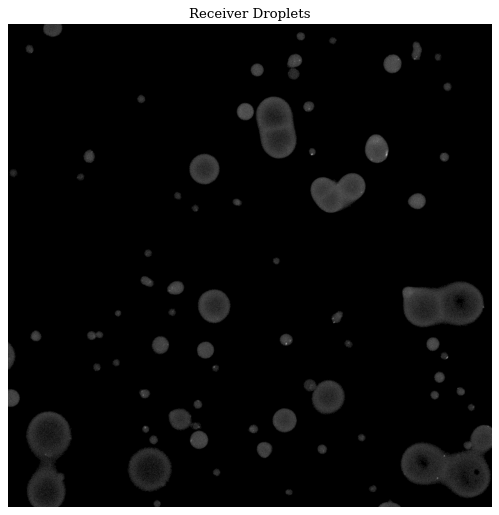

In [19]:
blank = np.zeros_like(sender_image)

for droplet in receivers:

    minr, minc, maxr, maxc = droplet.bbox
    
    cropped = receiver_image[minr:maxr, minc:maxc]
    
    mask = droplet.image
    
    for r in range(minr, maxr):
        for c in range(minc, maxc):
            r_r = r - minr
            r_c = c - minc
            if mask[r_r, r_c]:
                blank[r, c] = cropped[r_r, r_c]
    
figure = plt.figure(figsize=(8, 8), dpi = 80)

plt.title("Receiver Droplets")

plt.imshow(blank, cmap = 'gray')

plt.axis(False)

# save_ome_tif("Txn_series6_30min_receiver_cropped.tif", blank.reshape(1, 2048, 2048))

plt.show()

## Time Series

In [20]:
series_sender_values, series_receiver_values = [], []

for i in [0, 30, 60]:
    sender_image = plt.imread("./Sample_Data/Txn_series1_{:.0f}min_sender.tif".format(i))
    receiver_image = plt.imread("./Sample_Data/Txn_series1_{:.0f}min_receiver.tif".format(i))
    
    senders, receivers = droplet_detection(sender_image, receiver_image)
    sender_value = droplet_value_extraction_v2(senders, receiver_image)
    receiver_value = droplet_value_extraction_v2(receivers, receiver_image, dilation = True)
    series_sender_values.append(sender_value)
    series_receiver_values.append(receiver_value)

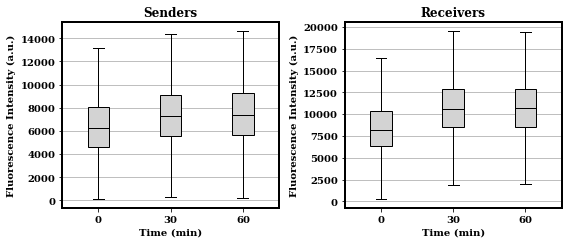

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5))

bplot1 = ax1.boxplot(series_sender_values,
                   labels = ["0", "30", "60"],
                   showfliers=False, # dont show outliers
                   vert=True,  # vertical box alignment
                   patch_artist=True)

bplot2 = ax2.boxplot(series_receiver_values,
                   labels = ["0", "30", "60"],
                   showfliers=False, # dont show outliers
                   vert=True,  # vertical box alignment
                   patch_artist=True)

ax1.yaxis.grid(True)
ax1.set_title("Senders", weight = "bold")
ax1.set_xlabel("Time (min)", weight = "bold")
ax1.set_ylabel("Fluorescence Intensity (a.u.)", weight = "bold")

ax2.yaxis.grid(True)
ax2.set_title("Receivers", weight = "bold")
ax2.set_xlabel("Time (min)", weight = "bold")
ax2.set_ylabel("Fluorescence Intensity (a.u.)", weight = "bold")


for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], ["lightgray", "lightgray", "lightgray"]):
        patch.set_facecolor(color)  
    for median in bplot['medians']:
        median.set_color('black')
        
plt.tight_layout()
    
plt.show()

<ipython-input-22-188aa4ca3d35>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.arange(0, 20000, 2500), rotation=30)
<ipython-input-22-188aa4ca3d35>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(np.arange(0, 20000, 2500), rotation=30)


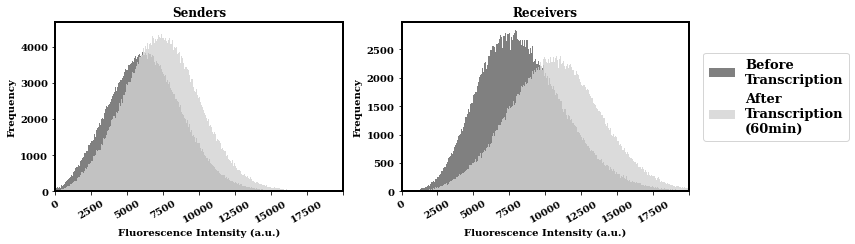

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.5))

ax1.hist(series_sender_values[0], bins = 1000, color = 'grey')
ax1.hist(series_sender_values[2], bins = 1000, color = 'lightgrey', alpha = .8)

ax1.set_title("Senders", weight = "bold")
ax1.set_xlabel("Fluorescence Intensity (a.u.)", weight = "bold")
ax1.set_ylabel("Frequency", weight = "bold")
ax1.set_xticklabels(np.arange(0, 20000, 2500), rotation=30)
ax1.set_xlim(0, 20000)

ax2.hist(series_receiver_values[0], bins = 1000, color = 'grey', label = "Before\nTranscription")
ax2.hist(series_receiver_values[2], bins = 1000, color = 'lightgrey', alpha = .8, label = "After\nTranscription\n(60min)")

ax2.set_title("Receivers", weight = "bold")
ax2.set_xlabel("Fluorescence Intensity (a.u.)", weight = "bold")
ax2.set_ylabel("Frequency", weight = "bold")
ax2.set_xticklabels(np.arange(0, 20000, 2500), rotation=30)
ax2.set_xlim(0, 20000)

plt.legend(loc=(1.05, 0.3))
      
plt.tight_layout()
    
plt.show()

## Scatter Plot for Droplet

In [23]:
img1 = plt.imread("./Sample_Data/Txn_25min_s3c1.tif")

img2 = plt.imread("./Sample_Data/Txn_25min_s3c2.tif")

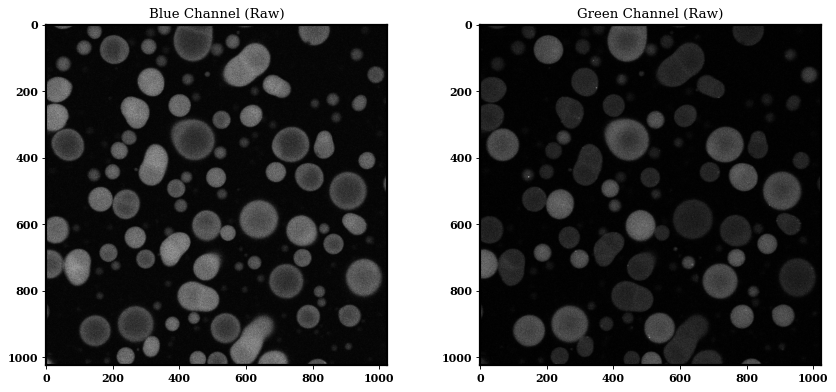

In [24]:
fig = plt.figure(figsize=(11, 5), dpi = 80)

plt.subplot(1, 2, 1)
plt.title("Blue Channel (Raw)")
plt.imshow(img1, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Green Channel (Raw)")
plt.imshow(img2, cmap="gray")

plt.tight_layout()
plt.show()

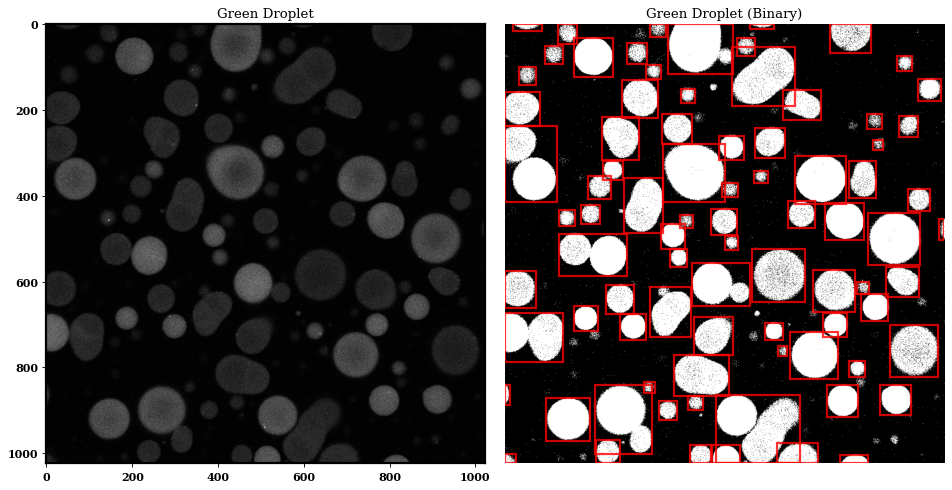

In [25]:
# Create Binary for better signal to noise
binary = img2 > (img2.mean() + 0.0*img2.std())

# use labeling function to identify connected blobs
label_im = label(binary)
blob_lists = regionprops(label_im)

# Remove small blobs
droplets = [i for i in blob_lists if i.area > 200]

plt.figure(figsize = (12, 6), dpi = 80)

plt.subplot(1, 2, 1)
plt.title("Green Droplet")
plt.imshow(img2, cmap = 'gray')

ax = plt.subplot(1, 2, 2)
plt.title("Green Droplet (Binary)")
plt.imshow(binary, cmap = 'gray')
for i in droplets:
    minr, minc, maxr, maxc = i.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2, alpha=.8)
    ax.add_patch(rect)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [26]:
val1, val2 = [], []

for droplet in droplets:
    
    # get the boundary
    minr, minc, maxr, maxc = droplet.bbox
    
    # img1 values
    blob_img = img1[minr:maxr, minc:maxc]
    vals = blob_img[binary_dilation(droplet.image)]
    val1.append(vals.flatten())
    
    # img2 values
    blob_img = img2[minr:maxr, minc:maxc]
    vals = blob_img[binary_dilation(droplet.image)]
    val2.append(vals.flatten())

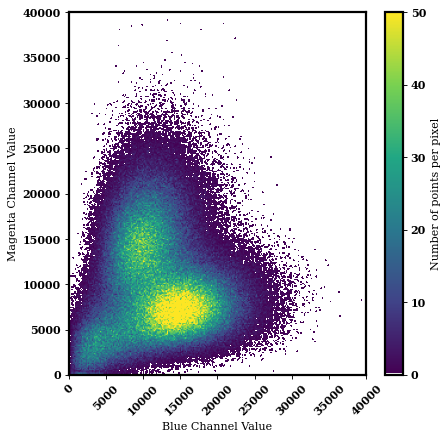

In [28]:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

fig = plt.figure(figsize=(6, 6), dpi = 80)
axi = fig.add_subplot(1, 1, 1, projection='scatter_density')

min_value = 0
max_value = 50

norm = Normalize(vmin=min_value, vmax=max_value)

# plt.scatter([val for ary in val1 for val in ary], [val for ary in val2 for val in ary], s = .1, cmap='white_viridis')
density = axi.scatter_density([val for ary in val1 for val in ary], [val for ary in val2 for val in ary], cmap=white_viridis, norm = norm)
#fig = plt.figure(figsize=(6, 6), dpi = 80)
fig.colorbar(density, label='Number of points per pixel')
# plt.title("Before Transcription")
plt.ylabel("Magenta Channel Value")
plt.xlabel("Blue Channel Value")
# "Viridis-like" colormap with white background
plt.xlim(0, 40000)
plt.ylim(0, 40000)
plt.xticks(rotation=45)
# plt.savefig('Txn_25min_NT-A_NR-B.png', dpi=400)
plt.show()

### Intensity Distribution based on droplet sizes

In [29]:
sender_image = plt.imread("./Sample_Data/Txn_series1_60min_sender.tif")
receiver_image = plt.imread("./Sample_Data/Txn_series1_60min_receiver.tif")

senders, receivers = droplet_detection(sender_image, receiver_image)

areas, diamters, values = [], [], []

for blob in receivers:
    # get the size(area) of the blob
    areas.append(blob.area)
    diamters.append(2*np.sqrt(blob.area/np.pi)*319.45/2048)
    # get the diameter
    minr, minc, maxr, maxc = blob.bbox
    blob_img = receiver_image[minr:maxr, minc:maxc]
    vals = blob_img[blob.image]
    values.append(vals)
    
receivers_df = pd.DataFrame({"area (pixel)":areas, 'diamter (um)':diamters, 'values':values})
receivers_df["means"] = receivers_df["values"].apply(np.mean)

areas, diamters, values = [], [], []

for blob in senders:
    # get the size(area) of the blob
    areas.append(blob.area)
    diamters.append(2*np.sqrt(blob.area/np.pi)*319.45/2048)
    # get the diameter
    minr, minc, maxr, maxc = blob.bbox
    blob_img = receiver_image[minr:maxr, minc:maxc]
    vals = blob_img[blob.image]
    values.append(vals)
    
senders_df = pd.DataFrame({"area (pixel)":areas, 'diamter (um)':diamters, 'values':values})
senders_df["means"] = senders_df["values"].apply(np.mean)

In [30]:
receivers_df.head()

,area (pixel),diamter (um),values,means
0,4646,11.996860,"[6765, 7014, 7060, 7058, 8400, 8324, 12486, 10...",11646.556608
1,604,4.325601,"[7404, 8572, 8011, 6437, 10850, 9996, 11262, 1...",9832.307947
2,1449,6.699805,"[7121, 8832, 10570, 10712, 14318, 14642, 15240...",11053.333333
3,607,4.336330,"[6581, 6542, 6354, 9296, 7780, 7580, 7092, 945...",8795.965404
4,3444,10.329031,"[6718, 8186, 6779, 6968, 6552, 7560, 6414, 112...",12296.536295


In [31]:
senders_df.head()

,area (pixel),diamter (um),values,means
0,4158,11.349330,"[5728, 8870, 5164, 9044, 5892, 9682, 5801, 813...",8798.760221
1,2962,9.579008,"[4104, 7330, 1809, 3352, 8077, 2139, 4825, 879...",8371.541864
2,769,4.880802,"[1685, 808, 1915, 2075, 1481, 3227, 1993, 2545...",5010.631990
3,2195,8.246037,"[2540, 1225, 1373, 4354, 1408, 4778, 5502, 163...",6845.262870
4,890,5.250770,"[189, 1516, 637, 1969, 1490, 1793, 2556, 1784,...",4398.749438


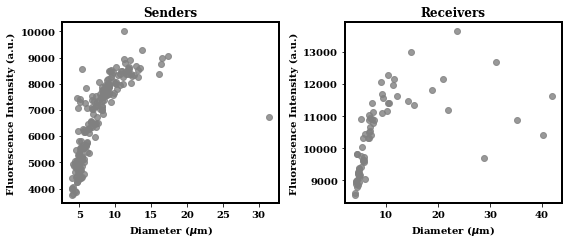

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5))

ax1.scatter(senders_df['diamter (um)'], senders_df['means'], color = "grey", alpha = .8)

ax2.scatter(receivers_df['diamter (um)'], receivers_df['means'], color = "grey", alpha = .8)

ax1.set_title("Senders", weight = "bold")
ax1.set_xlabel("Diameter ($\mu$m)", weight = "bold")
ax1.set_ylabel("Fluorescence Intensity (a.u.)", weight = "bold")

ax2.set_title("Receivers", weight = "bold")
ax2.set_xlabel("Diameter ($\mu$m)", weight = "bold")
ax2.set_ylabel("Fluorescence Intensity (a.u.)", weight = "bold")
        
plt.tight_layout()
    
plt.show()

In [33]:
def adv_concat(lst):
    try:
        lst = np.concatenate(lst)
    except:
        lst = np.array(lst)
    return lst

d5, d7_5, d10, d20, d30, d40, d50 = [], [], [], [], [], [], []

for i in range(len(senders_df)):
    if senders_df.iloc[i, 1] <= 5:
        d5.append(senders_df.iloc[i, 2])
    elif senders_df.iloc[i, 1] <= 7.5:
        d7_5.append(senders_df.iloc[i, 2])
    elif senders_df.iloc[i, 1] <= 10:
        d10.append(senders_df.iloc[i, 2])
    elif senders_df.iloc[i, 1] <= 20:
        d20.append(senders_df.iloc[i, 2])
    elif senders_df.iloc[i, 1] <= 30:
        d30.append(senders_df.iloc[i, 2])
    elif senders_df.iloc[i, 1] <= 40:
        d40.append(senders_df.iloc[i, 2])
    else:
        d50.append(senders_df.iloc[i, 2])

d5 = adv_concat(d5)
d7_5 = adv_concat(d7_5)
d10 = adv_concat(d10)
d20 = adv_concat(d20)
d30 = adv_concat(d30)
d40 = adv_concat(d40)
d50 = adv_concat(d50)

senders_dist = [d5, d7_5, d10, d20, d30, d40, d50]

d5, d7_5, d10, d20, d30, d40, d50 = [], [], [], [], [], [], []

for i in range(len(receivers_df)):
    if receivers_df.iloc[i, 1] <= 5:
        d5.append(receivers_df.iloc[i, 2])
    elif receivers_df.iloc[i, 1] <= 7.5:
        d7_5.append(receivers_df.iloc[i, 2])
    elif receivers_df.iloc[i, 1] <= 10:
        d10.append(receivers_df.iloc[i, 2])
    elif receivers_df.iloc[i, 1] <= 20:
        d20.append(receivers_df.iloc[i, 2])
    elif receivers_df.iloc[i, 1] <= 30:
        d30.append(receivers_df.iloc[i, 2])
    elif receivers_df.iloc[i, 1] <= 40:
        d40.append(receivers_df.iloc[i, 2])
    else:
        d50.append(receivers_df.iloc[i, 2])

d5 = adv_concat(d5)
d7_5 = adv_concat(d7_5)
d10 = adv_concat(d10)
d20 = adv_concat(d20)
d30 = adv_concat(d30)
d40 = adv_concat(d40)
d50 = adv_concat(d50)

receivers_dist = [d5, d7_5, d10, d20, d30, d40, d50]

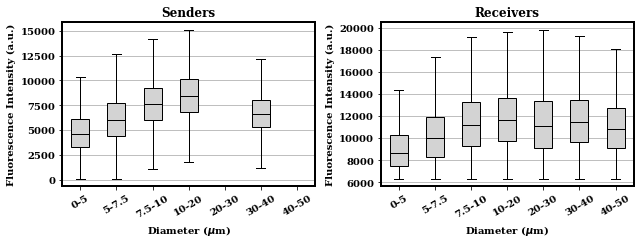

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.5))

bplot1 = ax1.boxplot(senders_dist,
                   showfliers=False, # dont show outliers
                   vert=True,  # vertical box alignment
                   patch_artist=True)

bplot2 = ax2.boxplot(receivers_dist,
                   showfliers=False, # dont show outliers
                   vert=True,  # vertical box alignment
                   patch_artist=True)

ax1.yaxis.grid(True)
ax1.set_title("Senders", weight = "bold")
ax1.set_xlabel("Diameter ($\mu$m)", weight = "bold")
ax1.set_xticklabels(["0-5", "5-7.5", "7.5-10", "10-20", "20-30", "30-40", "40-50"], rotation = 30)
ax1.set_ylabel("Fluorescence Intensity (a.u.)", weight = "bold")

ax2.yaxis.grid(True)
ax2.set_title("Receivers", weight = "bold")
ax2.set_xlabel("Diameter ($\mu$m)", weight = "bold")
ax2.set_xticklabels(["0-5", "5-7.5", "7.5-10", "10-20", "20-30", "30-40", "40-50"], rotation = 30)
ax2.set_ylabel("Fluorescence Intensity (a.u.)", weight = "bold")


for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], ["lightgray", "lightgray", "lightgray", "lightgray", "lightgray", "lightgray", "lightgray"]):
        patch.set_facecolor(color)  
    for median in bplot['medians']:
        median.set_color('black')
        
plt.tight_layout()
    
plt.show()

---
### Appendix

### Extract the pixel values of droplets - Threshold Method

In [ ]:
def droplet_value_extraction(droplets, image, filename = False, threshold = .75):
    """
    Extract the intensity value of the droplets. Can save as a txt file for later plotting.
    """
    
    values = []
    
    for blob in droplets:
        
        minr, minc, maxr, maxc = blob.bbox
        blob_img = image[minr:maxr, minc:maxc]
        vals = blob_img.flatten()
        background = np.quantile(image.flatten(), threshold)
        
        # Remove the background values
        vals = vals[vals > background]
        values.append(vals)
        
    values = np.concatenate(values)
    
    if filename: np.savetxt(filename, values, fmt='%f')
    
    return values

In [ ]:
sender_values = droplet_value_extraction(senders, receiver_image)

print("Mean:\t{:.2f}\nStd:\t{:.2f}\nMin:\t{:.2f}\nMax:\t{:.2f}".format(np.mean(sender_values), np.std(sender_values), np.min(sender_values), np.max(sender_values)))

plt.hist(sender_values, bins = 1000)
plt.xlim(0, 20000)
plt.show()

In [ ]:
receiver_values = droplet_value_extraction(receivers, receiver_image,\
                                           threshold = .75)

print("Mean:\t{:.2f}\nStd:\t{:.2f}\nMin:\t{:.2f}\nMax:\t{:.2f}".format(np.mean(receiver_values), np.std(receiver_values), np.min(receiver_values), np.max(receiver_values)))


plt.hist(receiver_values, bins = 1000)
plt.xlim(0, 20000)
plt.show()
np.mean(receiver_values)

### Notes

In [ ]:
senders, receivers = droplet_detection(sender_image, receiver_image)

In [ ]:
droplet_annotation(receiver_image, senders, RAW = False)
droplet_annotation(receiver_image, receivers, RAW = False)

In [ ]:
droplet = receivers[59]
droplet.area

In [ ]:
minx, miny, maxx, maxy = droplet.bbox
minx, miny, maxx, maxy, (maxx-minx)*(maxy-miny)

In [ ]:
plt.imshow(receiver_image[minx:maxx, miny:maxy], cmap = 'gray')

In [ ]:
plt.imshow(droplet.image, cmap = 'gray')

In [ ]:
from scipy.ndimage.morphology import binary_dilation

plt.imshow(binary_dilation(droplet.image), cmap = 'gray')

In [ ]:
values = receiver_image[minx:maxx, miny:maxy][droplet.image]
np.min(values), np.max(values), np.mean(values), np.std(values)

In [ ]:
for droplet in senders:
    minx, miny, maxx, maxy = droplet.bbox
    values = receiver_image[minx:maxx, miny:maxy][droplet.image]
    print(np.min(values), np.max(values), np.mean(values), np.std(values))


In [ ]:
ctr = 0
for droplet in receivers:
    minx, miny, maxx, maxy = droplet.bbox
    values = receiver_image[minx:maxx, miny:maxy][droplet.image]
    print(ctr, droplet.area, np.min(values), np.max(values), np.mean(values), np.std(values))
    ctr+=1
